In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from itertools import chain

In [3]:
# helpers
def safe_date_parse(date_str):
    try:
        return pd.to_datetime(date_str, format='%Y-%m-%d').value / 10**9
    except ValueError:
        return 0
    
import warnings
warnings.filterwarnings('ignore') # noisy scikit

In [4]:
stg_df_raw = pd.read_csv('data/stg_raw.csv')

# format wallet to string
stg_df_raw['Wallet Address'] = stg_df_raw['Wallet Address'].astype(str)

# format time diff colunm
stg_df_raw['Time Difference'] = stg_df_raw['Time Difference'].str.replace(' days', '').str.split(',').str[0]
stg_df_raw['Time Difference'] = pd.to_numeric(stg_df_raw['Time Difference'], errors='coerce')

# format date objects
stg_df_raw['First day of paired TX'] = stg_df_raw['First day of paired TX'].apply(safe_date_parse)
stg_df_raw['Wallet activation day (arbitrum)'] = stg_df_raw['Wallet activation day (arbitrum)'].apply(safe_date_parse)
stg_df_raw['Wallet activation day (polygon)'] = stg_df_raw['Wallet activation day (polygon)'].apply(safe_date_parse)
stg_df_raw['First tx'] = stg_df_raw['First tx'].apply(safe_date_parse)
stg_df_raw['Last tx'] = stg_df_raw['Last tx'].apply(safe_date_parse)

# remove nan rows
stg_df_raw = stg_df_raw.dropna()

print(stg_df_raw.dtypes)
print(stg_df_raw.describe())

Wallet Address                               object
In the list?                                float64
Average Time Between Paired TX (minutes)    float64
Total Sybil Volume                          float64
Total Number of Paired TX                   float64
Time Difference                             float64
First day of paired TX                      float64
Wallet activation day (arbitrum)            float64
Wallet activation day (polygon)             float64
TX Count                                    float64
Source chains                               float64
Dest chains                                 float64
Contracts                                   float64
Days                                        float64
Weeks                                       float64
Months                                      float64
First tx                                    float64
Last tx                                     float64
dtype: object
       In the list?  Average Time Between Paired T

In [5]:
sybil_df_raw = pd.read_csv('data/sybil_list.csv')
print(sybil_df_raw.dtypes)
print(sybil_df_raw.describe())
sybils = list(chain(*sybil_df_raw.values.tolist()))

ADDRESS    object
dtype: object
                                           ADDRESS
count                                      1113429
unique                                     1105613
top     0xe25067047f3410f176218577e7634eb4f954279c
freq                                             3


In [6]:
# Add new column for wallets that were detected as sybil from the final layerzero data
print(stg_df_raw["Wallet Address"])
stg_df_raw["detected"] = np.where(stg_df_raw["Wallet Address"].isin(sybils), True, False)
stg_df_raw[stg_df_raw.detected == True]
print(stg_df_raw.dtypes)


0        0xfeddd2c18a0b9ba04fc7bfe2395f162b4f43e35c
1        0xcc7c8df2ac2da555cb3d3b66b2fe1ba759ae81fc
2        0xf93d4d0ca8f20c1c91cb29d7325d8de403052733
3        0x0baa5feae8f31912503bc0808eb07fa3ff5ba7bf
4        0x7ec16e9a0073c07914d358770887bae77ca87c27
                            ...                    
11272    0x436cc2507488fae9d1e2222a9dc4bcc7f20bd5c6
11273    0x3c6bbed8ffd7601add523208de6c944a9618ba5f
11274    0x75a48bc10180a0bc2f50560f1b4fec71b01fe7ec
11275    0x2b623d7f850bcfc1ff7c34913abc8d5c18e3d762
11276    0x1b5c0da673acd42c6f6bd8a6c93d1329551028f8
Name: Wallet Address, Length: 11096, dtype: object
Wallet Address                               object
In the list?                                float64
Average Time Between Paired TX (minutes)    float64
Total Sybil Volume                          float64
Total Number of Paired TX                   float64
Time Difference                             float64
First day of paired TX                      float64
Wallet activa

In [7]:
# statsmodels to fit a multiple linear regression model, 50% split
sybil_train, sybil_test = train_test_split(stg_df_raw, random_state = 90, test_size = 0.5)

In [8]:
# remove wallet addresses as they don't provide any information individually
# remove detected as it is the target variable
x_train, x_test = sybil_train.drop(['Wallet Address', 'detected'], axis=1), sybil_test.drop(['Wallet Address', 'detected'], axis=1)

In [9]:
X_train = sm.add_constant(x_train)
OLSModel = sm.OLS(sybil_train['detected'], X_train).fit()

print("Training set R squared value: " + str(OLSModel.rsquared))
X_test = sm.add_constant(x_test)
print("Test set R squared value: " + str(r2_score(sybil_test['detected'], OLSModel.predict(X_test))))

Training set R squared value: 0.5448162047612806
Test set R squared value: 0.5249176070914724


In [10]:
# Print summary with estimated coefficients
print(OLSModel.summary())

print("\n Statistically significant (p < 0.05): \n", OLSModel.pvalues < 0.05)

                            OLS Regression Results                            
Dep. Variable:               detected   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     389.3
Date:                Sun, 21 Jul 2024   Prob (F-statistic):               0.00
Time:                        16:59:43   Log-Likelihood:                -1500.4
No. Observations:                5548   AIC:                             3037.
Df Residuals:                    5530   BIC:                             3156.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

Statistically significant variables (p < 0.05): `In the list?`, `Average Time Between Paired TX (minutes)`, `Total Sybil Volume`, `Time Difference`, `First day of paired TX`, `Wallet activation day (arbitrum)`, `Wallet activation day (polygon)`, `TX Count`, `Source chains`, `Days`, `Weeks`, `Months`, `First tx`, `Last tx`.

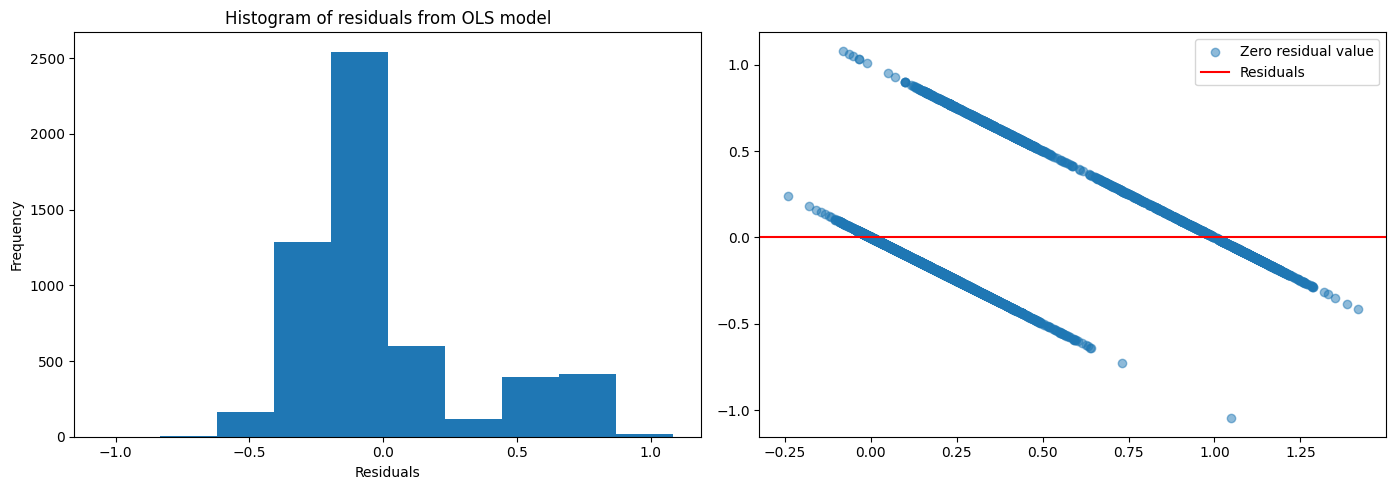

In [11]:
# 1 x 2 grid
plot, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

# Histogram of residuals
axes[0].hist(OLSModel.resid)
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of residuals from OLS model')

# Residuals of fitted model as a function of the predicted values
axes[1].scatter(OLSModel.fittedvalues, OLSModel.resid, alpha = 0.5)
axes[1].axhline(y = 0, color = 'r', linestyle = '-')
axes[1].legend(['Zero residual value', 'Residuals'])

# Adjust subploits dimensions
plot.subplots_adjust(wspace=10)
plot.tight_layout()

**Linearity:** This linear regression model follows linearity as the relationship between the residual fitted values as a function of the predicted values is linear.

**Normality:** Distribution of residuals (histogram) is right-skewed and not normally skewed

In [12]:
# drop dates with high multicollinearity
multi_collinear = ['Wallet activation day (arbitrum)', 'Wallet activation day (polygon)', 'First tx', 'Last tx', 'First day of paired TX']
x2_train = x_train.drop(multi_collinear, axis=1)
x2_test = x_test.drop(multi_collinear, axis=1)

print(x2_train.columns.values)

['In the list?' 'Average Time Between Paired TX (minutes)'
 'Total Sybil Volume' 'Total Number of Paired TX' 'Time Difference'
 'TX Count' 'Source chains' 'Dest chains' 'Contracts' 'Days' 'Weeks'
 'Months']


In [13]:
def scale_datasets(train_data, test_data, cols_to_scale):
    """
    This function standardizes columns in dataset. It
    also to pass in a test dataset, which will be standardized
    using the stats from the training data. 

    :param: train: The training dataset
    :param: test: The test dataset, which will be standardized using stats 
                  from the training data. 
    :param: cols_to_scale: List containing the column names to be standardized
    :return: (DataFrame, DataFrame) Standardized test and training DataFrames
    """
    train = train_data.copy().reset_index(drop=True)
    test = test_data.copy().reset_index(drop=True)

    for column in cols_to_scale:
        std = np.std(train_data[column])
        mean = np.mean(train_data[column])

        # (df-df.mean())/df.std()
        train[column] = train[column].apply(lambda x: (x - mean) / std)
        test[column] = test[column].apply(lambda x: (x - mean) / std)

    return train, test


binary_columns = ['In the list']

standarize_columns = x2_train.columns.difference(binary_columns)
# Remove const as std = 0 error at standarization
standarize_columns = standarize_columns.difference(['const', 'year'])

practice_X_train = x2_train.copy()
practice_X_test = x2_test.copy()

practice_X_train_scaled, practice_X_test_scaled = scale_datasets(practice_X_train, practice_X_test, standarize_columns)
practice_X_train_scaled.head(1)

,In the list?,Average Time Between Paired TX (minutes),Total Sybil Volume,Total Number of Paired TX,Time Difference,TX Count,Source chains,Dest chains,Contracts,Days,Weeks,Months
0,2.161666,-0.568371,0.597396,0.369994,-0.334912,-0.403605,0.29559,-0.586641,-0.720891,-0.33228,-0.752982,-1.099145


In [14]:
def split_columns(df, target_col, drop_columns):
    """
    :param: df: DataFrame
    :param: target_col: The name of the response variable
    :param: drop_columns: List containing the column names to drop
    :return: (X_train, y_train)
    """
    y_train = df[target_col]
    X_train = df.drop(drop_columns, axis = 1)

    return X_train, y_train

augment dataset with higher-order features:

In [15]:
def add_poly_features(dataset, degree, columns):
    """
    :param dataset: Dataset
    :param degree: Max degree
    :return: Augmented DataFrame
    """
    poly_dataset = dataset.copy().reset_index(drop=True)
    polynomial = PolynomialFeatures(degree, include_bias = False)
    for col in columns:
        feature_col = polynomial.fit_transform(dataset[col].values.reshape(-1, 1))
        df = pd.DataFrame(feature_col)
        list_names = []
        for deg in range(degree):
            # rename first degree as normal text variable
            if deg == 0:
                variable_name = str(col)
            else:
                variable_name = str(col) + '_' + str(deg + 1)
            list_names.append(variable_name)
        
        df.columns = list_names
        # Drop normal variable to prevent repetition of columns
        poly_dataset.drop(col, axis = 1, inplace=True)
        poly_dataset = pd.merge(poly_dataset, df, left_index=True, right_index=True)
    
    return poly_dataset

features = ['Total Sybil Volume', 'Average Time Between Paired TX (minutes)', 'Time Difference']
practice_X_train_poly = add_poly_features(practice_X_train_scaled, 3, features)

print(practice_X_train_poly.columns.values)

['In the list?' 'Total Number of Paired TX' 'TX Count' 'Source chains'
 'Dest chains' 'Contracts' 'Days' 'Weeks' 'Months' 'Total Sybil Volume'
 'Total Sybil Volume_2' 'Total Sybil Volume_3'
 'Average Time Between Paired TX (minutes)'
 'Average Time Between Paired TX (minutes)_2'
 'Average Time Between Paired TX (minutes)_3' 'Time Difference'
 'Time Difference_2' 'Time Difference_3']


In [16]:
def build_interaction(df, interact_left, interact_right):
    """
    :param df: data
    :param interact_left: The first set of columns to use in interactions
    :param interact_right: The set of columns  to generate interactions terms
                           with in interact_left
    """
    for left in interact_left:
        for right in interact_right:
            interaction = df[left] * df[right]
            name_col = str(left) + '_' + str(right)
            df[name_col] = interaction
            
    return df

numeric_predictors = ['Total Sybil Volume', 'Average Time Between Paired TX (minutes)', 'Time Difference']
dummies = ['TX Count', 'Contracts']

practice_X_train_poly = build_interaction(practice_X_train_poly, numeric_predictors, dummies)
print(practice_X_train_poly.columns.values)

['In the list?' 'Total Number of Paired TX' 'TX Count' 'Source chains'
 'Dest chains' 'Contracts' 'Days' 'Weeks' 'Months' 'Total Sybil Volume'
 'Total Sybil Volume_2' 'Total Sybil Volume_3'
 'Average Time Between Paired TX (minutes)'
 'Average Time Between Paired TX (minutes)_2'
 'Average Time Between Paired TX (minutes)_3' 'Time Difference'
 'Time Difference_2' 'Time Difference_3' 'Total Sybil Volume_TX Count'
 'Total Sybil Volume_Contracts'
 'Average Time Between Paired TX (minutes)_TX Count'
 'Average Time Between Paired TX (minutes)_Contracts'
 'Time Difference_TX Count' 'Time Difference_Contracts']


In [17]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['Total Sybil Volume', 'Average Time Between Paired TX (minutes)', 'Time Difference'],
                    target_col='detected', 
                    bad_columns=['Wallet Address', 'detected']):
    """
    :param train_df: The training data
    :param val_df: test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns to drop
    """
    # Split columns (train and validation)
    X_train_raw, y_train = split_columns(train_df, target_col, bad_columns)
    X_validation_raw, y_val = split_columns(val_df, target_col, bad_columns)
    
    # from standarization step
    standarize_columns = X_train_raw.columns.difference(binary_columns)
    
    X_train_scaled = X_train_raw.copy()
    X_validation_scaled = X_validation_raw.copy()
    X_train_scaled, X_validation_scaled = scale_datasets(X_train_scaled, X_validation_scaled, standarize_columns)
    
    # Polynomial terms
    X_train_poly = add_poly_features(X_train_scaled, degree, columns_forpoly)
    X_validation_poly = add_poly_features(X_validation_scaled, degree, columns_forpoly)

    # Interaction terms
    date_dummies = dummies
    x_train = build_interaction(X_train_poly, columns_forpoly, date_dummies)
    x_val = build_interaction(X_validation_poly, columns_forpoly, date_dummies)
    
    return x_train, y_train, x_val, y_val

x_train, y_train, x_val, y_val = get_design_mats(sybil_train, sybil_test,  degree = 3)

display(x_train.describe())

,In the list?,Total Number of Paired TX,First day of paired TX,Wallet activation day (arbitrum),Wallet activation day (polygon),TX Count,Source chains,Dest chains,Contracts,Days,...,Average Time Between Paired TX (minutes)_3,Time Difference,Time Difference_2,Time Difference_3,Total Sybil Volume_TX Count,Total Sybil Volume_Contracts,Average Time Between Paired TX (minutes)_TX Count,Average Time Between Paired TX (minutes)_Contracts,Time Difference_TX Count,Time Difference_Contracts
count,5.548000e+03,5.548000e+03,5.548000e+03,5.548000e+03,5.548000e+03,5.548000e+03,5.548000e+03,5.548000e+03,5.548000e+03,5.548000e+03,...,5548.000000,5.548000e+03,5548.000000,5548.000000,5548.000000,5548.000000,5548.000000,5548.000000,5548.000000,5548.000000
mean,4.354444e-17,3.842156e-17,-3.073725e-15,-8.362453e-15,1.255104e-16,7.428168e-17,-4.098300e-17,-1.075804e-16,1.479230e-16,1.857042e-17,...,4.789924,2.129195e-17,1.000000,5.333699,0.228877,-0.022986,-0.074900,-0.019389,-0.095423,-0.017998
std,1.000090e+00,1.000090e+00,1.000090e+00,1.000090e+00,1.000090e+00,1.000090e+00,1.000090e+00,1.000090e+00,1.000090e+00,1.000090e+00,...,59.387162,1.000090e+00,6.347786,56.604032,1.500577,0.619626,0.808229,1.077767,0.616476,0.660295
min,-4.626061e-01,-7.413907e-01,-3.087316e+00,-2.780758e+00,-6.994341e+00,-1.345066e+00,-2.891071e+00,-1.940692e+00,-1.646417e+00,-1.352174e+00,...,-0.313150,-3.349120e-01,0.000419,-0.037566,-6.661547,-8.357767,-7.156592,-16.176569,-3.978186,-3.574361
25%,-4.626061e-01,-3.709291e-01,-9.478881e-01,-6.736938e-01,1.202678e-01,-8.429533e-01,-8.994075e-01,-7.370915e-01,-6.180552e-01,-8.082305e-01,...,-0.125812,-3.349120e-01,0.112166,-0.037566,-0.196031,-0.160855,-0.339554,-0.232632,-0.274726,-0.164273
50%,-4.626061e-01,-4.674174e-04,4.061063e-01,-1.299353e-01,1.354084e-01,-1.211669e-01,2.955904e-01,-1.352912e-01,-2.067104e-01,-6.030876e-02,...,-0.044983,-3.349120e-01,0.112166,-0.037566,0.044660,0.041111,-0.007554,0.019615,0.027366,0.029345
75%,-4.626061e-01,-4.674174e-04,9.453595e-01,3.934323e-01,1.574808e-01,6.320015e-01,6.939230e-01,4.665091e-01,3.074706e-01,5.516272e-01,...,0.003238,-3.349120e-01,0.112166,-0.037566,0.294565,0.233672,0.234669,0.203396,0.271805,0.206994
max,2.161666e+00,1.370661e+01,1.265785e+00,1.786813e+00,2.435814e-01,5.841416e+00,4.677249e+00,4.528661e+00,5.449281e+00,3.611307e+00,...,1767.583202,9.622427e+00,92.591097,890.951055,7.703234,3.879876,8.799945,13.466399,3.123361,4.306920


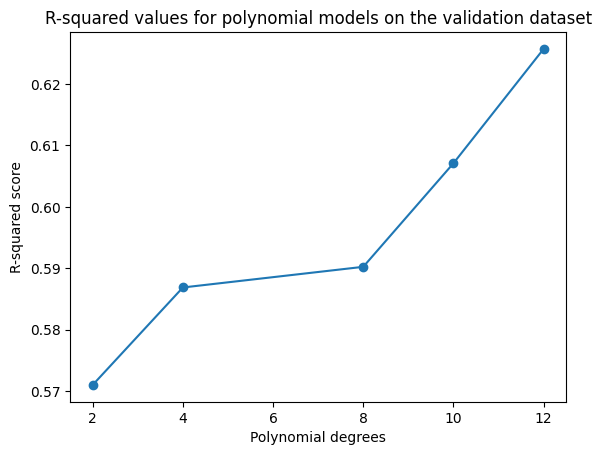

Highest r^2 value of: 0.6257226953761789 for polynomial degree = 12


In [18]:
degrees = [2,4,8,10,12]
r2_scores = []

for degree in degrees:
    x_train, y_train, x_val, y_val = get_design_mats(sybil_train, sybil_test,  degree = degree)
    
    X_train = sm.add_constant(x_train.values)
    OLSModel = sm.OLS(y_train, X_train).fit()
    
    X_test = sm.add_constant(x_val.values)
    r2_deg = r2_score(y_val, OLSModel.predict(X_test))
    r2_scores.append(r2_deg)
    
plt.plot(degrees, r2_scores, marker='o')
plt.title('R-squared values for polynomial models on the validation dataset')
plt.ylabel('R-squared score')
plt.xlabel('Polynomial degrees')
plt.show()

print('Highest r^2 value of: ' + str(max(r2_scores)) + ' for polynomial degree = ' + str(degrees[r2_scores.index(max(r2_scores))]))

In [19]:
detected_test, detected_val = train_test_split(sybil_train, random_state=109, test_size=.2)

In [20]:
r2_scores = []
alphas = np.exp(np.arange(-10,11,1))

x_train, y_train, x_val, y_val = get_design_mats(sybil_train, detected_val,  degree = 12)

for alpha in alphas:
    ridge = Ridge(alpha = alpha).fit(x_train, y_train)
    # Ridge normalize=True removes Ill-conditioned matrix warning?
    print(x_val)
    print(y_val)
    r2 = ridge.score(x_val, y_val)
    r2_scores.append(r2)

r2_table = pd.DataFrame(r2_scores, index =[alphas], columns =['R-squared'])
r2_table

      In the list?  Total Number of Paired TX  First day of paired TX  \
0        -0.462606                  -0.000467               -1.039717   
1         2.161666                  -0.370929                0.710902   
2        -0.462606                  -0.000467               -1.524264   
3        -0.462606                   0.369994                1.195448   
4         2.161666                   0.369994               -0.453573   
...            ...                        ...                     ...   
1105     -0.462606                  -0.370929                0.742163   
1106     -0.462606                  -0.741391                0.710902   
1107     -0.462606                  -0.370929                0.937544   
1108     -0.462606                   0.369994                0.757793   
1109      2.161666                  -0.741391               -1.016272   

      Wallet activation day (arbitrum)  Wallet activation day (polygon)  \
0                            -0.163920          

,R-squared
0.000045,0.571556
0.000123,0.550803
0.000335,0.550995
0.000912,0.594692
0.002479,0.596064
0.006738,0.599623
0.018316,0.607412
0.049787,0.607516
0.135335,0.620258
0.367879,0.637094


In [21]:
max_r2 = max(r2_scores)
best_alpha = alphas[r2_scores.index(max(r2_scores))]
print('Highest r-squared value of: ' + str(max_r2) + ' for ridge model with alpha = ' + str(best_alpha) + ' and polynomial degree of 15 for the validation dataset.')

Highest r-squared value of: 0.6404604604386783 for ridge model with alpha = 1.0 and polynomial degree of 15 for the validation dataset.


In [22]:
x_train, y_train, x_val, y_val = get_design_mats(sybil_train, sybil_test,  degree = 12)

# OLS model
OLSModel = LinearRegression().fit(x_train, y_train)
r2_OLSModel = r2_score(y_val, OLSModel.predict(x_val))
print('OLS Model R-squared: ' + str(r2_OLSModel))

# Lasso model
lasso = LassoCV(alphas=alphas, max_iter=100000).fit(x_train, y_train)
print('Lasso Model R-squared: ' + str(lasso.score(x_val, y_val)) + ' (alpha = ' + str(lasso.alpha_) + ')')

OLS Model R-squared: 0.6253602181167104
Lasso Model R-squared: 0.5918905489455765 (alpha = 0.00033546262790251185)


<Axes: title={'center': 'Main features coefficent values for OLS, Ridge, and Lasso models'}, ylabel='features'>

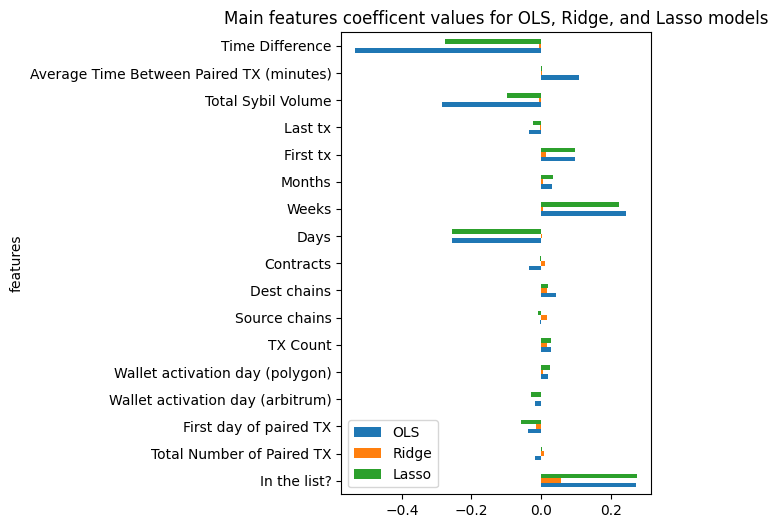

In [27]:
features = list(sybil_train.columns.values)

dataframe_features = pd.concat([pd.DataFrame(x_train.columns),pd.DataFrame(np.transpose(OLSModel.coef_)),pd.DataFrame(np.transpose(ridge.coef_)),pd.DataFrame(np.transpose(lasso.coef_))], axis = 1)
dataframe_features.columns = ['features', 'OLS', 'Ridge', 'Lasso']
for index, row in dataframe_features.iterrows():
    if row['features'] not in features:
        dataframe_features = dataframe_features.drop(index)

dataframe_features = dataframe_features.set_index('features')
dataframe_features.plot.barh(figsize=(4, 6), title='Main features coefficent values for OLS, Ridge, and Lasso models')